In [39]:
from typing import Optional, Union, Tuple, Dict, Iterator

import sympy
import numpy as np
from sympy import Eq, plot_implicit, Matrix, plot, symbols, latex, simplify
from sympy import Expr, Basic
from sympy.core import sympify
from sympy.core.relational import Equality
from sympy.plotting.plot import Plot
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Line2D
from sympy.core.symbol import _symbol
from sympy import pi as Pi
from sympy import cos as Cos
from sympy import sin as Sin
from sympy.geometry.entity import GeometryEntity, GeometrySet
import matplotlib.pyplot as plt
from IPython.display import Latex

# Практическое занятие 15
# Компьютерный практикум по алгебре на Python
## Кривые второго порядка на плоскости: парабола

### Задание 1
Определить класс parabola по образцу класса Гипербола из ЛР 14.

Реализовать **атрибуты**: 

**парамет**р $p$

**вершина** (vertex) в виде точки Point

**фокус** (focus) в виде точки Point

**угол angle** по умолчанию 0 для параболы с осью, параллельной OX, и ветвями, направленными вправо

**ось симметрии** (axis_symmetry) в виде прямой Line

**директриса** (directrix) в виде прямой Line

Реализовать **методы** 

**equation(self)** - уравнение параболы,

**dir_equation(self)** - уравнение директрисы,

**ax_sym_equation(self**) - уравнение оси симметрии,

**rotate(self, angle)** - поворот на угол angle против часовой стрелки, метод не изменяет параболу, а возвращает параболу с теми же p и вершиной, но угол увеличен на angle по сравнению с исходной параболой. 

В конструкторе экземпляра класса  

__new__(cls, p, vertex=None, angle=None)

p - обязательный параметр, а вид параболы по умолчанию  - парабола с осью, параллельной оси OX,
вершина по умолчанию в начале координат.

In [40]:
class Parabola(GeometrySet):
    """
     Attributes
    ==========
    p
    vertex
    angle
    focus
    axis_symmetry
    directrix
    ==========
    Methods
    ==========
    equation
    dir_equation
    ax_sym_equation
    rotate
    """
    def __new__(
        cls,
        p: Union[int, float, Expr],
        vertex: Optional[Union[Tuple[Union[int, float, Expr], Union[int, float, Expr]], Point2D]]=None,
        angle: Optional[Union[int, float, Expr]]=None,
        **kwargs
    ) -> 'Parabola':
        if not isinstance(p, (int, float, Expr)):
            raise NotImplementedError()
        
        if not isinstance(p, Expr):
            p: Expr = sympify(p)
        
        if not isinstance(angle, Expr):
            angle: Expr = \
                sympify(angle) \
                if isinstance(angle, (int, float)) else \
                (sympify(0) if p > 0 else Pi)
        
        if isinstance(vertex, tuple):
            vertex: Point2D = Point2D(vertex[0], vertex[1])
        elif not isinstance(vertex, Point2D):
            vertex: Point2D = Point2D(0, 0)

        angle_cos = Cos(angle)
        angle_sin = Sin(angle)

        directrix_x: Expr = vertex.x - p/2
        if angle_sin == 0:
            focus: Point2D = Point2D(vertex.x + p/2, vertex.y)
            axis_symmetry: Line2D = Line2D(vertex, focus)
            directrix: Line2D = Line2D(Point2D(directrix_x, -1), Point(directrix_x, 1))
        else:
            A: Matrix = Matrix([
                [angle_cos, -angle_sin],
                [angle_sin, angle_cos]
            ])

            A_: Matrix = A * Matrix((p/2, 0))
            focus: Point2D = Point2D(A_[0, 0] + vertex.x, A_[1, 0] + vertex.y)
            axis_symmetry: Line2D = \
                Line2D(vertex, slope=sympy.tan(angle)) \
                if angle_cos != 0 else \
                Line2D(vertex, focus)
            directrix_matrix: Matrix = Matrix([
                [directrix_x, directrix_x],
                [-1, 1],            
            ])

            directrix_matrix = A * directrix_matrix
            directrix = Line2D(
                Point2D(directrix_matrix[0, 0], directrix_matrix[1, 0]),
                Point2D(directrix_matrix[0, 1], directrix_matrix[1, 1])
            )
        
        A1: Matrix = Matrix([
            [angle_cos, angle_sin],
            [-angle_sin, angle_cos]
        ])

        return GeometryEntity.__new__(cls, p, vertex, angle, focus, axis_symmetry, directrix, (A1,), *symbols('x y'), **kwargs) # type: ignore

    @property
    def p(self) -> Expr:
        return self.args[0]

    @property
    def vertex(self) -> Point2D:
        return self.args[1]

    @property
    def angle(self) -> Expr:
        return self.args[2]

    @property
    def focus(self) -> Point2D:
        return self.args[3]

    @property
    def axis_symmetry(self) -> Line2D:
        return self.args[4]

    @property
    def directrix(self) -> Line2D:
        return self.args[5]

    @property
    def free_symbols(self) -> Tuple[Expr, Expr]:
        return (self.args[7], self.args[8])

    @property
    def __inversed_rotation_matrix(self) -> Matrix:
        return self.args[6][0]

    def equation(self) -> Equality:
        x, y = self.free_symbols
        vertex: Point2D = self.args[1]
        x0: Expr = vertex.x
        y0: Expr = vertex.y
        p: Expr = self.args[0]

        X: Matrix = Matrix([x - x0, y - y0])
        X = self.__inversed_rotation_matrix * X
        return Eq((X[1])**2, 2*p*(X[0]))

    def ax_sym_equation(self) -> Equality:
        free_symbols: Tuple[Expr, Expr] = self.free_symbols
        eq: Expr = self.axis_symmetry.equation(*free_symbols)
        symbs: Dict[str, Expr] = {str(x): x for x in free_symbols}

        if 'y' in symbs:
            return Eq(symbs['y'], simplify(sympy.solve(eq, symbs['y'])[0]))

        return Eq(symbs['x'], simplify(sympy.solve(eq, symbs['x'])[0]))

    def dir_equation(self) -> Equality:
        eq: Expr = self.directrix.equation(*self.free_symbols)
        symbs: Dict[str, Expr] = {str(x): x for x in eq.free_symbols}
    
        symbol: Expr = symbs['y' if 'y' in symbs else 'x']
        return Eq(symbol, simplify(sympy.solve(eq, symbol)[0]))                

    def rotate(self, angle: Union[int, float, Expr]) -> 'Parabola':
        if isinstance(angle, (int, float)):
            angle: Expr = sympify(angle)
        elif not isinstance(angle, Expr):
            raise NotImplementedError()
        
        return Parabola(self.p, self.vertex, self.angle + angle)


In [41]:
from typing import overload, Union, Optional

@overload
def print_sympy_entity(text: Optional[str] = None) -> None:
    ...

@overload
def print_sympy_entity(text: Optional[str] = None, expression: Optional[Union[str, Basic]] = None, *, raw: bool = True) -> None:
    ...

@overload
def print_sympy_entity(text: Optional[str] = None, *expressions: Union[str, Basic], raw: bool = True) -> None:
    ...

def print_sympy_entity(*args, **kwargs) -> None:
    text: Optional[str] = kwargs.get("text", None)
    expression: Optional[Union[str, Basic]] = kwargs.get("expression", None)

    if text is None and args:
        text = args[0]
    
    expressions: list[str | Expr] = \
        [expr for expr in args[1:] if isinstance(expr, (str, Basic))] \
        if len(args) > 1 else []

    if expression is not None:
        expressions.append(expression)

    if not expressions:
        if text is not None:
            display(Latex("$\\text{" + text + "}$"))
        return
    
    is_raw: bool = kwargs.get("raw", True)
    if len(expressions) == 1:
        final_expr = '$' + (latex(expressions[0]) if is_raw else expressions[0]) + '$'
    else:
        final_expr: str = \
            r'$\\' + r'\\'.join(map(latex, expressions) if is_raw else expressions) + '$'

    if text is not None:
        final_expr = "$\\text{" + text + "}$ " + final_expr

    display(Latex(final_expr))


### Задание 2
Построить параболу с $p = 3$, вершиной в (-5, 2), осью симметрии, образующей угол $\pi/4$ с положительным направлением оси ОХ. Вывести на экран ее параметр p, вершину, угол, фокус, ось симметрии и директрису, а также уравнение параболы, оси симметрии и директрисы. 

Изобразить на общем графике параболу, ее ось симметрии и директрису, парабола зеленая, ось симметрии красная, директриса черная. 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

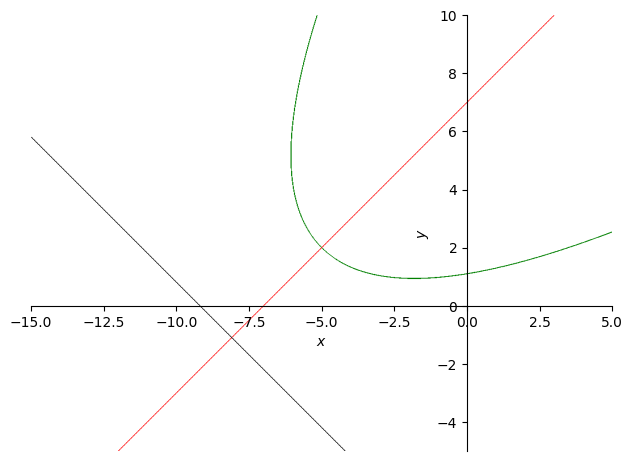

In [42]:
parabola: Parabola = Parabola(3, (-5, 2), Pi/4)
print_sympy_entity("p:", parabola.p)
print_sympy_entity("vertex:", parabola.vertex)
print_sympy_entity("angle:", parabola.angle)
print_sympy_entity("focus:", parabola.focus)
axis_symmetry: Line2D = parabola.axis_symmetry
print_sympy_entity("axis:", axis_symmetry)
directrix: Line2D = parabola.directrix
print_sympy_entity("directrix:", directrix)

parabola_eq: Equality = parabola.equation()
axis_symmetry_eq: Equality = parabola.ax_sym_equation()
directrix_eq: Equality = parabola.dir_equation()

print_sympy_entity("parabola equation:", parabola_eq)
print_sympy_entity("axis equation:", axis_symmetry_eq)
print_sympy_entity("directrix equation:", directrix_eq)

symbs: Dict[str, Expr] = {str(s): s for s in parabola.free_symbols}
x: Expr = symbs['x']
y: Expr = symbs['y']

colors: Iterator[str] = iter(('g', 'r', 'k'))
p: Plot = plot(
    aspect_ratio=(1, 1), 
    axis_center=(0, 0),
    xlim=(-15, 5), 
    ylim=(-5, 10),
    xlabel='$x$',
    ylabel='$y$',
    show=False
)
p.extend(plot_implicit(
    parabola_eq,
    (x, -15, 5),
    (y, -5, 10),
    line_color=next(colors),
    show=False,
))
p.extend(plot_implicit(
    axis_symmetry_eq,
    (x, -15, 5),
    (y, -5, 10),
    line_color=next(colors),
    show=False
))
p.extend(plot_implicit(
    directrix_eq,
    (x, -15, 5),
    (y, -5, 10),
    line_color=next(colors),
    show=False,
))

p.show()

### Индивидуальное задание
Построить параболу из своего варианта, построить другую параболу путем поворота исходной параболы  на угол $\alpha$ радиан. Вывести на экран вершину, угол, фокус, ось симметрии и директрису обеих парабол. 

Использовать уравнения повернутой параболы, ее оси симметрии и директрисы для построения графиков в одной координатной плоскости. Парабола фиолетовая, ось симметрии зеленая, директриса черная, название графика Парабола, подписи осей $x$ и $y$.

Вариант N 50

Центр $Point2D\left(3, 0\right)$, парабола вида $y^{2} = 2px$ с $p = 2$. Угол поворота $\pi / 6$.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

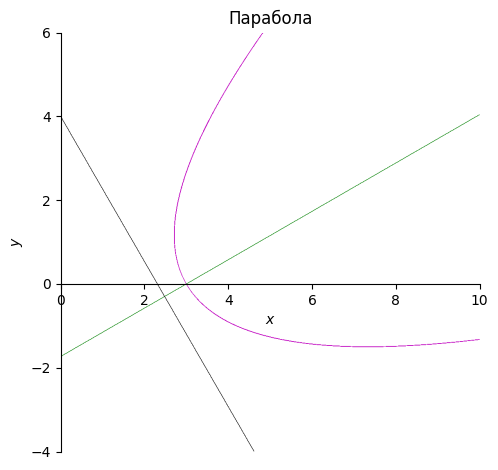

In [43]:
def print_parabola_data(parabola: Parabola) -> None:
    print_sympy_entity("p:", parabola.p)
    print_sympy_entity("Вершина:", parabola.vertex)
    print_sympy_entity("Угол поворота:", parabola.angle)
    print_sympy_entity("Фокус:", parabola.focus)
    axis_symmetry: Line2D = parabola.axis_symmetry
    print_sympy_entity("Ось симметрии:", axis_symmetry)
    directrix: Line2D = parabola.directrix
    print_sympy_entity("Директриса:", directrix)

p: int = 2
vertex: Point2D = Point2D(3, 0)
angle: Expr = Pi/6
parabola: Parabola = Parabola(p, vertex)
rotated_parabola: Parabola = parabola.rotate(angle)

print_sympy_entity("Данная парабола:")
print_parabola_data(parabola)
print_sympy_entity("Повёрнутая парабола:")
print_parabola_data(rotated_parabola)

parabola_eq: Equality = rotated_parabola.equation()
axis_symmetry_eq: Equality = rotated_parabola.ax_sym_equation()
directrix_eq: Equality = rotated_parabola.dir_equation()

symbs: Dict[str, Expr] = {str(s): s for s in rotated_parabola.free_symbols}
x: Expr = symbs['x']
y: Expr = symbs['y']

X_BORDERS: Tuple[int, int] = (0, 10)
Y_BORDERS: Tuple[int, int] = (-4, 6)
colors: Iterator[str] = iter(('m', 'g', 'k'))
p: Plot = plot(
    aspect_ratio=(1, 1), 
    axis_center=(0, 0),
    xlim=X_BORDERS, 
    ylim=Y_BORDERS,
    title="Парабола",
    xlabel='$x$',
    ylabel='$y$',
    show=False
)
equations: Tuple[Equality, Equality, Equality] = (parabola_eq, axis_symmetry_eq, directrix_eq)
for eq in equations:
    p.extend(plot_implicit(
        eq,
        (x, *X_BORDERS),
        (y, *Y_BORDERS),
        line_color=next(colors),
        show=False,
    ))

p.show()